In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

In [33]:
data_path = r"C:\Users\Mustafa Ansari\Downloads\Time series pro\Time_Series_Project-BBQ\Data\barbecue_sauce_sales.csv"
data = pd.read_csv(data_path, parse_dates=['date'], date_format='%m/%d/%Y')  # Specify format for your MM/DD/YYYY
print(data.head()) 

         date  amount
0  2020-01-03     285
1  2020-01-06     627
2  2020-01-07     241
3  2020-01-08     356
4  2020-01-09     877


In [34]:
# Ensure 'amount' is numeric
data['amount'] = pd.to_numeric(data['amount'], errors='coerce')

In [35]:
# Quick check
print(data.info())
print(data.describe())  # Added: Summary stats 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1386 entries, 0 to 1385
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    1386 non-null   object
 1   amount  1386 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 21.8+ KB
None
            amount
count  1386.000000
mean    483.370851
std     859.918769
min       0.000000
25%      35.000000
50%     105.000000
75%     522.000000
max    5703.000000


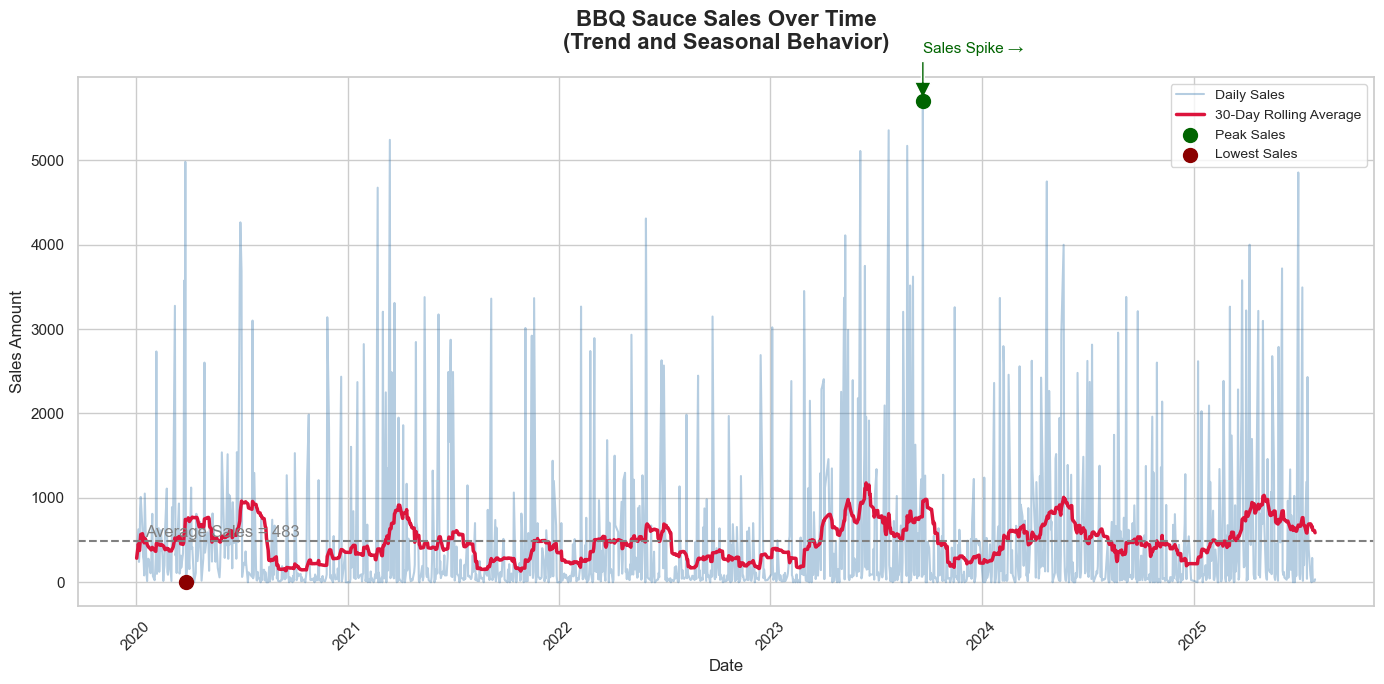

In [36]:

# Ensure proper datetime index
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date').sort_index()

# Add a rolling mean (7-day or 30-day smoothing, depending on data frequency)
data['rolling_mean'] = data['amount'].rolling(window=30, min_periods=1).mean()

# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(14, 7))

# Plot main time series
plt.plot(data.index, data['amount'], color='steelblue', alpha=0.4, label='Daily Sales')

# Add smoothed trend line
plt.plot(data.index, data['rolling_mean'], color='crimson', linewidth=2.5, label='30-Day Rolling Average')

# Highlight the maximum and minimum points
max_date = data['amount'].idxmax()
min_date = data['amount'].idxmin()
plt.scatter(max_date, data.loc[max_date, 'amount'], color='darkgreen', s=100, zorder=5, label='Peak Sales')
plt.scatter(min_date, data.loc[min_date, 'amount'], color='darkred', s=100, zorder=5, label='Lowest Sales')

# Add mean line
mean_sales = data['amount'].mean()
plt.axhline(y=mean_sales, color='gray', linestyle='--', linewidth=1.5)
plt.text(data.index[10], mean_sales + 50, f"Average Sales = {mean_sales:.0f}", color='gray')

# Annotations for storytelling
plt.annotate('Sales Spike →', xy=(max_date, data.loc[max_date, 'amount']),
             xytext=(max_date, data['amount'].max() * 1.1),
             arrowprops=dict(facecolor='darkgreen', shrink=0.05, width=2),
             fontsize=11, color='darkgreen')

# Title and labels
plt.title('BBQ Sauce Sales Over Time\n(Trend and Seasonal Behavior)', fontsize=16, weight='bold', pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales Amount', fontsize=12)

# Add legend
plt.legend(frameon=True, facecolor='white', fontsize=10)

# Rotate x-axis labels for clarity
plt.xticks(rotation=45)

# Tight layout for better spacing
plt.tight_layout()

plt.show()

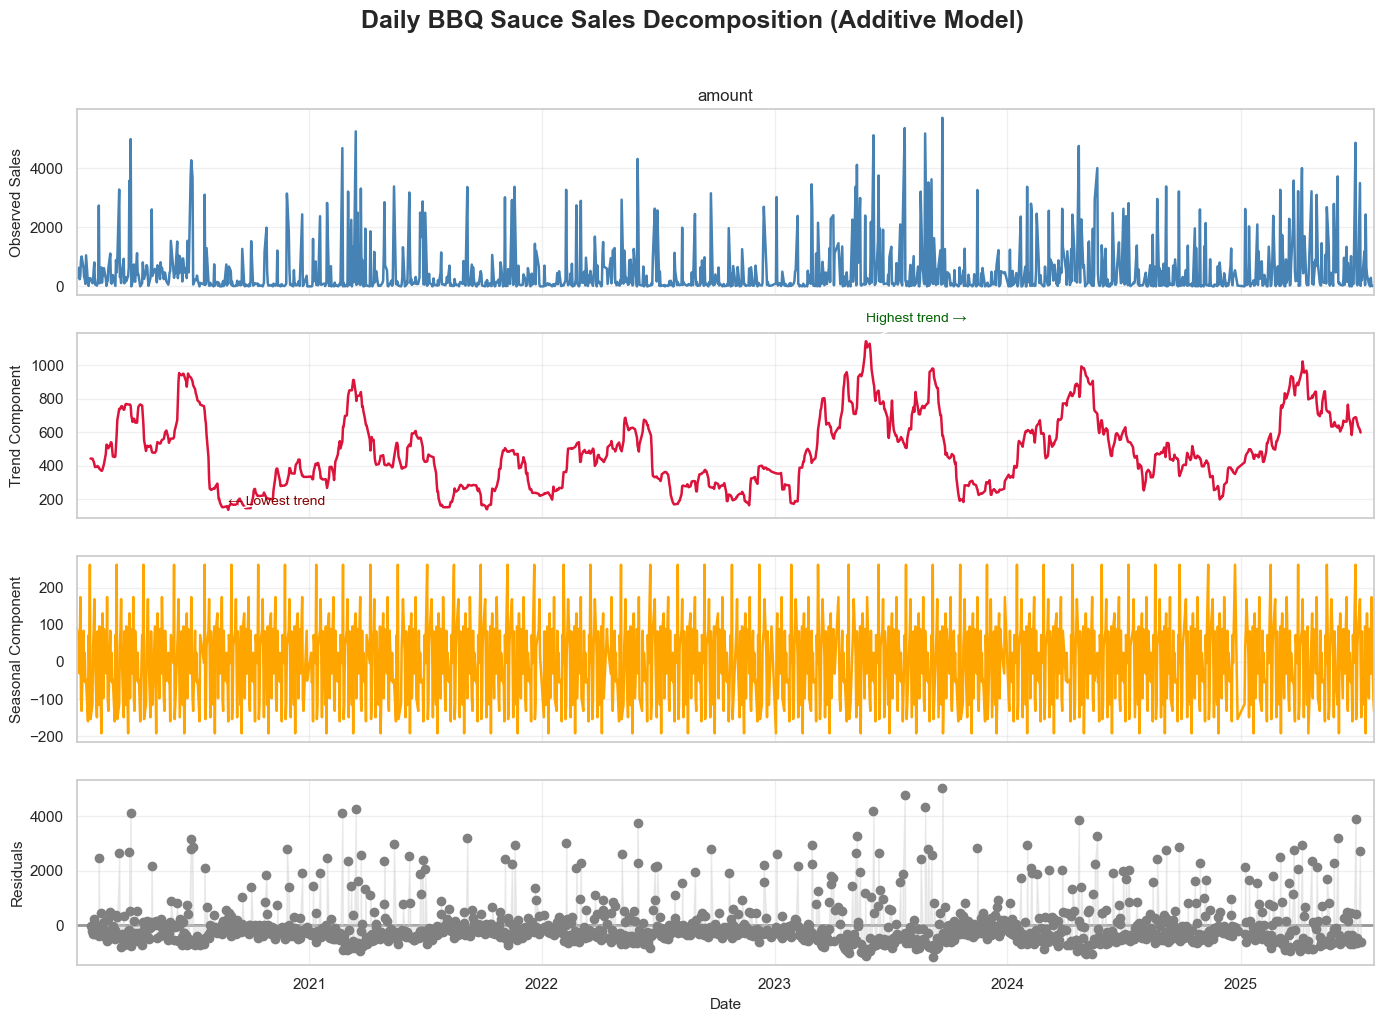

In [37]:


# Ensure index is datetime 
data.index = pd.to_datetime(data.index)
data = data.sort_index()


# 2. Perform decomposition

daily_decomp = seasonal_decompose(data['amount'], model='additive', period=30)


# 3. Set style and create plot

sns.set_style("whitegrid")
fig = daily_decomp.plot()
fig.set_size_inches(14, 10)


# 4. Titles and axis labels

fig.suptitle('Daily BBQ Sauce Sales Decomposition (Additive Model)', 
             fontsize=18, weight='bold', y=1.02)

ylabels = ['Observed Sales', 'Trend Component', 'Seasonal Component', 'Residuals']
for ax, ylabel in zip(fig.axes, ylabels):
    ax.set_ylabel(ylabel, fontsize=11)

fig.axes[3].set_xlabel('Date', fontsize=11)


# 5. Styling each subplot

colors = ['steelblue', 'crimson', 'orange', 'gray']
for ax, color in zip(fig.axes, colors):
    for line in ax.lines:
        line.set_color(color)
        line.set_linewidth(1.8)
    ax.grid(True, alpha=0.3)


# 6. Highlight residual variation

fig.axes[3].fill_between(
    data.index, 
    daily_decomp.resid, 
    color='lightgray', 
    alpha=0.4
)


# 7. Annotate key trend points

trend_series = daily_decomp.trend.dropna()
if not trend_series.empty:
    max_trend_date = trend_series.idxmax()
    min_trend_date = trend_series.idxmin()

    fig.axes[1].annotate('Highest trend →', 
                         xy=(max_trend_date, trend_series.max()), 
                         xytext=(max_trend_date, trend_series.max() * 1.1),
                         arrowprops=dict(facecolor='darkgreen', arrowstyle='->'),
                         color='darkgreen', fontsize=10)

    fig.axes[1].annotate('← Lowest trend', 
                         xy=(min_trend_date, trend_series.min()), 
                         xytext=(min_trend_date, trend_series.min() * 1.2),
                         arrowprops=dict(facecolor='darkred', arrowstyle='->'),
                         color='darkred', fontsize=10)


# 8. Layout and show

plt.tight_layout()
plt.show()


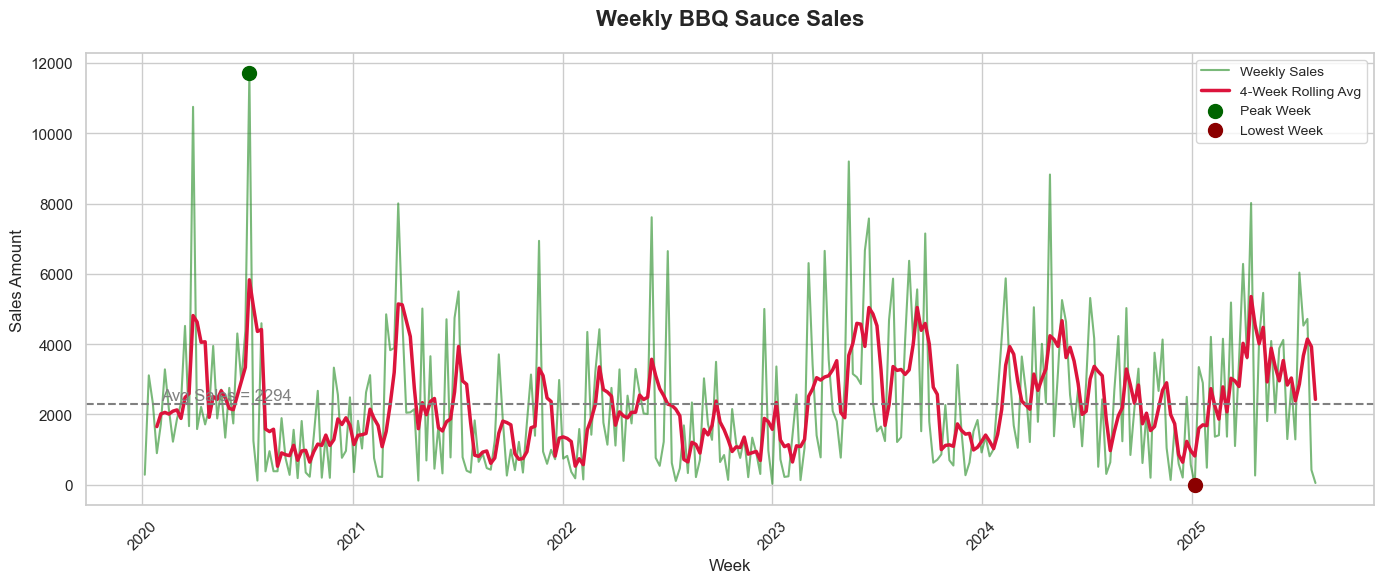

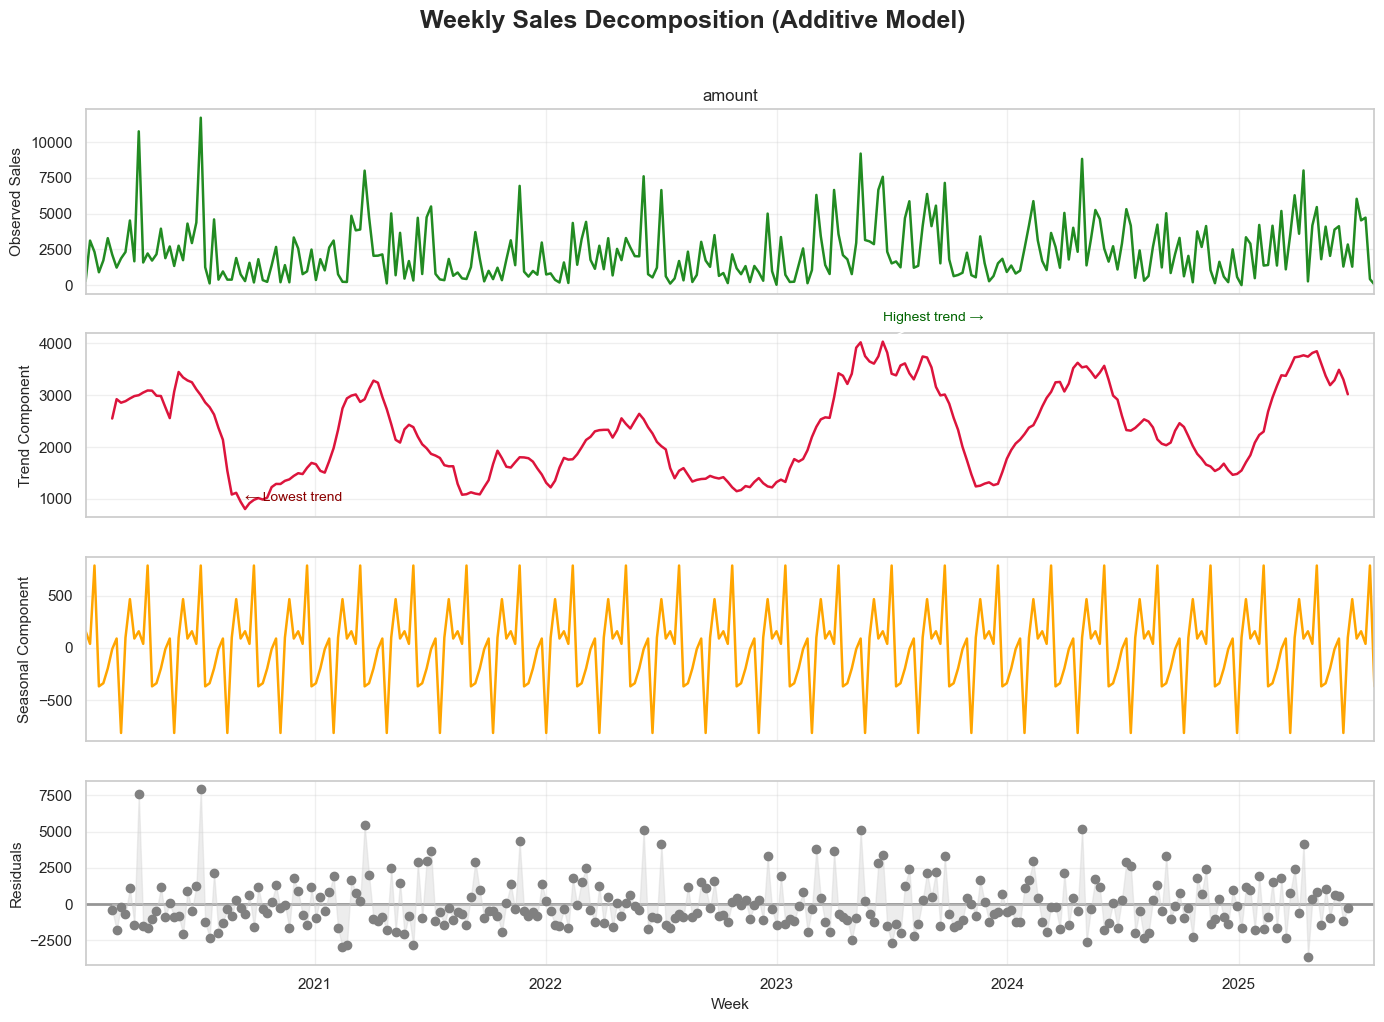

In [38]:
# 1. Weekly Sales Aggregation

weekly = data['amount'].resample('W').sum()  # sum sales per week

# Set seaborn style for polished visuals
sns.set_style("whitegrid")
plt.figure(figsize=(14,6))

# Plot weekly sales with trend line
plt.plot(weekly.index, weekly, color='forestgreen', alpha=0.6, label='Weekly Sales')
plt.plot(weekly.index, weekly.rolling(4).mean(), color='crimson', linewidth=2.5, label='4-Week Rolling Avg')

# Highlight max/min points
max_week = weekly.idxmax()
min_week = weekly.idxmin()
plt.scatter(max_week, weekly.max(), color='darkgreen', s=100, zorder=5, label='Peak Week')
plt.scatter(min_week, weekly.min(), color='darkred', s=100, zorder=5, label='Lowest Week')

# Mean line for reference
mean_weekly = weekly.mean()
plt.axhline(y=mean_weekly, color='gray', linestyle='--', linewidth=1.5)
plt.text(weekly.index[4], mean_weekly + mean_weekly*0.05, f"Avg Sales = {mean_weekly:.0f}", color='gray')

# Titles, labels, and legend
plt.title('Weekly BBQ Sauce Sales', fontsize=16, weight='bold', pad=20)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Sales Amount', fontsize=12)
plt.legend(frameon=True, facecolor='white', fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 2. Weekly Sales Decomposition

weekly_decomp = seasonal_decompose(weekly, model='additive', period=12)  # ~12 weeks per quarter

fig = weekly_decomp.plot()
fig.set_size_inches(14,10)
fig.suptitle('Weekly Sales Decomposition (Additive Model)', fontsize=18, weight='bold', y=1.02)

# Customize y-labels
ylabels = ['Observed Sales', 'Trend Component', 'Seasonal Component', 'Residuals']
for ax, ylabel in zip(fig.axes, ylabels):
    ax.set_ylabel(ylabel, fontsize=11)

fig.axes[3].set_xlabel('Week', fontsize=11)

# Improve line styles
colors = ['forestgreen', 'crimson', 'orange', 'gray']
for ax, color in zip(fig.axes, colors):
    for line in ax.lines:
        line.set_color(color)
        line.set_linewidth(1.8)
    ax.grid(True, alpha=0.3)

# Shade residuals for clarity
fig.axes[3].fill_between(weekly.index, weekly_decomp.resid, color='lightgray', alpha=0.4)

# Annotate key trend points
trend_series = weekly_decomp.trend.dropna()
if not trend_series.empty:
    max_trend_date = trend_series.idxmax()
    min_trend_date = trend_series.idxmin()
    fig.axes[1].annotate('Highest trend →', xy=(max_trend_date, trend_series.max()), 
                         xytext=(max_trend_date, trend_series.max()*1.1),
                         arrowprops=dict(facecolor='darkgreen', arrowstyle='->'),
                         color='darkgreen', fontsize=10)
    fig.axes[1].annotate('← Lowest trend', xy=(min_trend_date, trend_series.min()), 
                         xytext=(min_trend_date, trend_series.min()*1.2),
                         arrowprops=dict(facecolor='darkred', arrowstyle='->'),
                         color='darkred', fontsize=10)

plt.tight_layout()
plt.show()


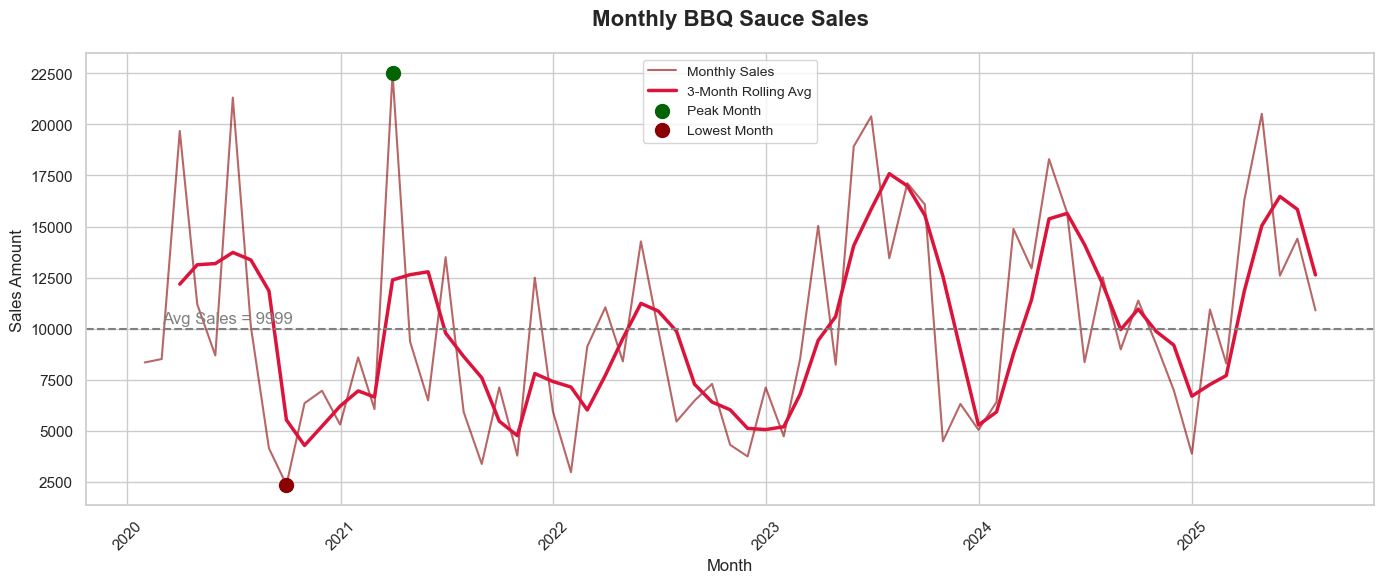

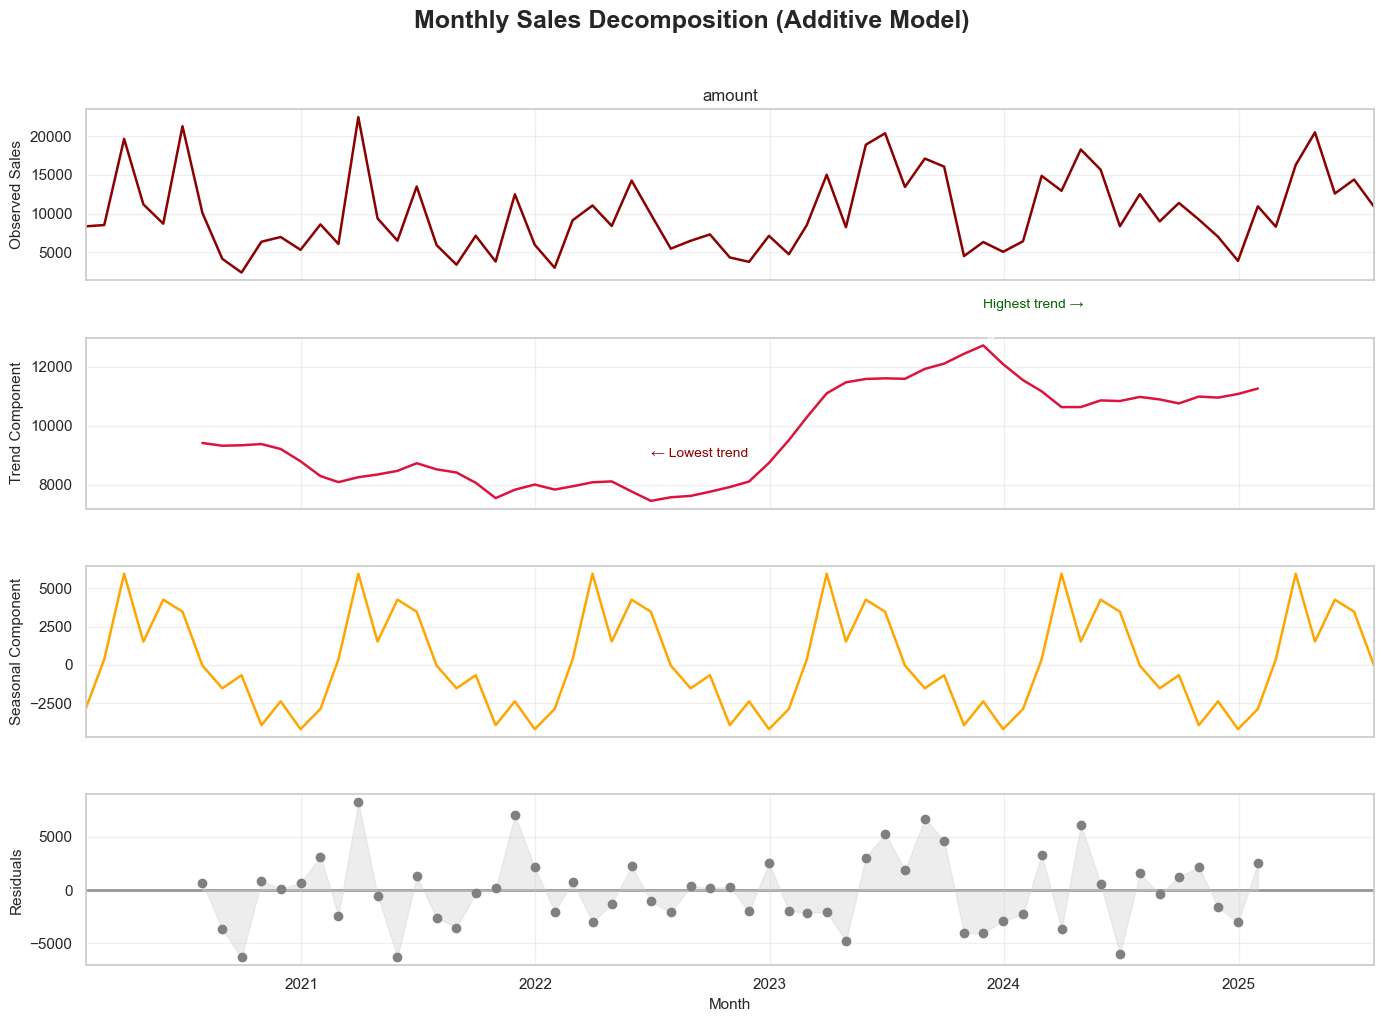

In [39]:

# 1. Monthly Sales Aggregation

monthly = data['amount'].resample('M').sum()  # sum sales per month

# Seaborn style for polished visuals
sns.set_style("whitegrid")
plt.figure(figsize=(14,6))

# Plot monthly sales with rolling trend line
plt.plot(monthly.index, monthly, color='darkred', alpha=0.6, label='Monthly Sales')
plt.plot(monthly.index, monthly.rolling(3).mean(), color='crimson', linewidth=2.5, label='3-Month Rolling Avg')

# Highlight max/min points
max_month = monthly.idxmax()
min_month = monthly.idxmin()
plt.scatter(max_month, monthly.max(), color='darkgreen', s=100, zorder=5, label='Peak Month')
plt.scatter(min_month, monthly.min(), color='darkred', s=100, zorder=5, label='Lowest Month')

# Mean line
mean_monthly = monthly.mean()
plt.axhline(y=mean_monthly, color='gray', linestyle='--', linewidth=1.5)
plt.text(monthly.index[1], mean_monthly + mean_monthly*0.03, f"Avg Sales = {mean_monthly:.0f}", color='gray')

# Titles, labels, legend
plt.title('Monthly BBQ Sauce Sales', fontsize=16, weight='bold', pad=20)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Sales Amount', fontsize=12)
plt.legend(frameon=True, facecolor='white', fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 2. Monthly Sales Decomposition

monthly_decomp = seasonal_decompose(monthly, model='additive', period=12)  # 12 months = 1 year

fig = monthly_decomp.plot()
fig.set_size_inches(14,10)
fig.suptitle('Monthly Sales Decomposition (Additive Model)', fontsize=18, weight='bold', y=1.02)

# Customize y-labels
ylabels = ['Observed Sales', 'Trend Component', 'Seasonal Component', 'Residuals']
for ax, ylabel in zip(fig.axes, ylabels):
    ax.set_ylabel(ylabel, fontsize=11)

fig.axes[3].set_xlabel('Month', fontsize=11)

# Improve line styles
colors = ['darkred', 'crimson', 'orange', 'gray']
for ax, color in zip(fig.axes, colors):
    for line in ax.lines:
        line.set_color(color)
        line.set_linewidth(1.8)
    ax.grid(True, alpha=0.3)

# Shade residuals
fig.axes[3].fill_between(monthly.index, monthly_decomp.resid, color='lightgray', alpha=0.4)

# Annotate key trend points
trend_series = monthly_decomp.trend.dropna()
if not trend_series.empty:
    max_trend_date = trend_series.idxmax()
    min_trend_date = trend_series.idxmin()
    fig.axes[1].annotate('Highest trend →', xy=(max_trend_date, trend_series.max()), 
                         xytext=(max_trend_date, trend_series.max()*1.1),
                         arrowprops=dict(facecolor='darkgreen', arrowstyle='->'),
                         color='darkgreen', fontsize=10)
    fig.axes[1].annotate('← Lowest trend', xy=(min_trend_date, trend_series.min()), 
                         xytext=(min_trend_date, trend_series.min()*1.2),
                         arrowprops=dict(facecolor='darkred', arrowstyle='->'),
                         color='darkred', fontsize=10)

plt.tight_layout()
plt.show()


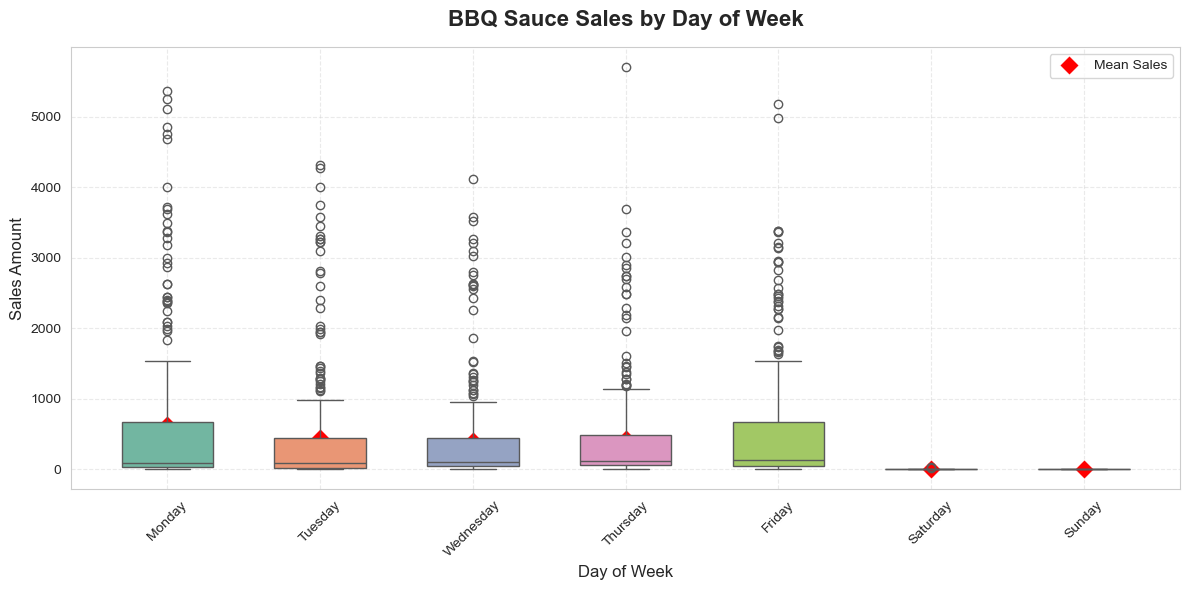

In [ ]:

# 1. Extract day of week

data['day_of_week'] = data.index.day_name()  
# Define order for consistent week display
week_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']


# 2. Create boxplot

sns.set_style("whitegrid")
plt.figure(figsize=(12,6))

# Boxplot with customized palette
sns.boxplot(
    x='day_of_week', 
    y='amount', 
    data=data,
    order=week_order,
    palette='Set2',
    showfliers=True,  # Show outliers explicitly
    width=0.6
)

# Overlay mean points
day_means = data.groupby('day_of_week')['amount'].mean().reindex(week_order)
sns.scatterplot(x=range(len(week_order)), y=day_means.values, 
                color='red', s=100, marker='D', label='Mean Sales')

# Titles, labels, and grid
plt.title('BBQ Sauce Sales by Day of Week', fontsize=16, weight='bold', pad=15)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Sales Amount', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(frameon=True)

plt.tight_layout()
plt.show()


In [40]:
# 1. Flag weekend vs weekday

data['is_weekend'] = np.where(data['day_of_week'].isin(['Saturday','Sunday']), 'Weekend', 'Weekday')

# 2. Create boxplot

sns.set_style("whitegrid")
plt.figure(figsize=(8,6))

# Boxplot with color palette
sns.boxplot(
    x='is_weekend', 
    y='amount', 
    data=data,
    palette=['#1f77b4', '#ff7f0e'],  
    showfliers=True,
    width=0.5
)

# Overlay mean sales as red diamonds
group_means = data.groupby('is_weekend')['amount'].mean()
sns.scatterplot(x=[0,1], y=group_means.values, color='red', s=100, marker='D', label='Mean Sales')

# Titles, labels, and grid
plt.title('BBQ Sauce Sales: Weekend vs Weekday', fontsize=16, weight='bold', pad=15)
plt.xlabel('')
plt.ylabel('Sales Amount', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(frameon=True)

plt.tight_layout()
plt.show()


KeyError: 'day_of_week'

Some invalid dates detected in climate_data:


,date,mean_temp_nationwide,min_temp_nationwide,max_temp_nationwide,mean_precipitation_mm_nationwide,min_precipitation_mm_nationwide,max_precipitation_mm_nationwide,mean_sun_hours_nationwide,min_sun_hours_nationwide,max_sun_hours_nationwide
6,NaT,5.22,3.1,7.3,0.22,0.0,1.0,1.166667,0.0,2.9
7,NaT,7.59,4.8,10.5,0.37,0.0,1.7,1.888889,0.0,7.5
8,NaT,8.98,4.9,11.7,0.28,0.0,1.5,4.355556,1.1,8.4
9,NaT,7.14,4.1,10.4,0.00,0.0,0.0,6.222222,4.8,7.1
10,NaT,5.93,2.9,8.6,1.09,0.0,4.9,4.544444,0.0,7.4



 Missing Data Report (after merge & cleaning):
amount       0
temp         4
precip       0
sun_hours    0
dtype: int64


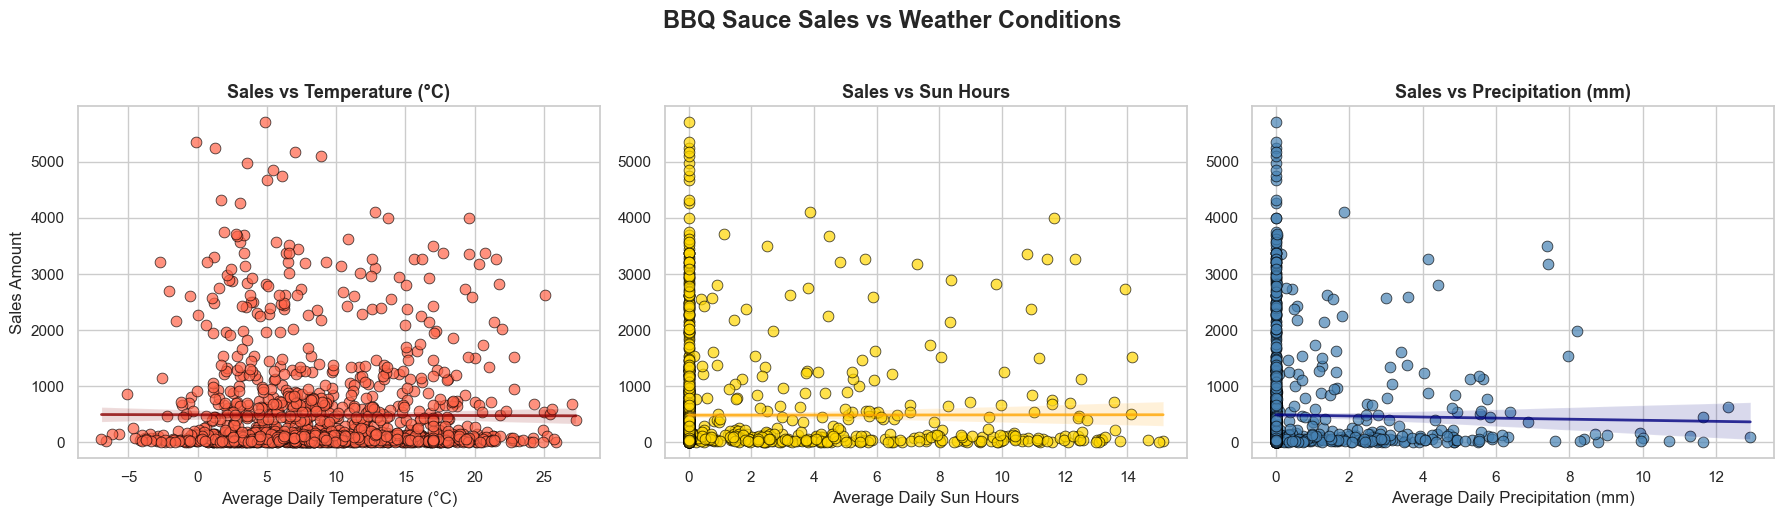


 Merge and Visualization Successful!
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1386 entries, 2020-01-03 to 2025-07-29
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   amount     1386 non-null   int64  
 1   temp       1382 non-null   float64
 2   precip     1386 non-null   float64
 3   sun_hours  1386 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 54.1 KB
None

 Preview of final merged data:


,amount,temp,precip,sun_hours
date,,,,
2020-01-03,285,NaN,0.00,0.000000
2020-01-06,627,NaN,0.00,0.000000
2020-01-07,241,NaN,0.00,0.000000
2020-01-08,356,NaN,0.00,0.000000
2020-01-09,877,14.76,1.23,3.722222


In [41]:

# Merge Sales Data with Climate Data + Enhanced Scatter Visualization

# Load and Prepare the Datasets

data = pd.read_csv(data_path)
climate_data_path = "C:\\Users\\Mustafa Ansari\\Downloads\\Time series pro\\Time_Series_Project-BBQ\\Data\\climate_data.csv"
climate_data = pd.read_csv(climate_data_path)

# Clean date column in climate data
climate_data['date'] = climate_data['date'].astype(str).str.strip()
climate_data['date'] = pd.to_datetime(climate_data['date'], dayfirst=True, errors='coerce')

# Check for invalid or NaT dates
if climate_data['date'].isna().sum() > 0:
    print("Some invalid dates detected in climate_data:")
    display(climate_data[climate_data['date'].isna()].head())

# Simplify column names for clarity
climate_data = climate_data.rename(columns={
    'mean_temp_nationwide': 'temp',
    'mean_precipitation_mm_nationwide': 'precip',
    'mean_sun_hours_nationwide': 'sun_hours'
})


# Prepare the Sales Data

# Ensure sales 'date' column is in datetime format
if 'date' in data.columns:
    data['date'] = pd.to_datetime(data['date'], errors='coerce')
    data.set_index('date', inplace=True)


# Merge Datasets (Left Join for Robustness)

merged = pd.merge(
    data,
    climate_data[['date', 'temp', 'precip', 'sun_hours']],
    on='date',
    how='left'
)
merged.set_index('date', inplace=True)


# Handle Missing Weather Data (Imputation)

# Interpolate smooth variables (temperature)
merged['temp'] = merged['temp'].interpolate(method='linear')

# Fill event-based features (rain & sun) with 0
merged['precip'].fillna(0, inplace=True)
merged['sun_hours'].fillna(0, inplace=True)


# Missingness Audit

print("\n Missing Data Report (after merge & cleaning):")
print(merged.isna().sum())


# Enhanced Side-by-Side Scatter Plots

sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Sales vs Temperature 
sns.scatterplot(
    data=merged, x='temp', y='amount',
    ax=axes[0], color='tomato', alpha=0.7, s=60, edgecolor='black'
)
sns.regplot(
    data=merged, x='temp', y='amount',
    ax=axes[0], scatter=False, color='darkred',
    line_kws={'linewidth': 2, 'alpha': 0.8}
)
axes[0].set_title('Sales vs Temperature (°C)', fontsize=13, weight='bold')
axes[0].set_xlabel('Average Daily Temperature (°C)')
axes[0].set_ylabel('Sales Amount')

# Plot 2: Sales vs Sun Hours 
sns.scatterplot(
    data=merged, x='sun_hours', y='amount',
    ax=axes[1], color='gold', alpha=0.7, s=60, edgecolor='black'
)
sns.regplot(
    data=merged, x='sun_hours', y='amount',
    ax=axes[1], scatter=False, color='orange',
    line_kws={'linewidth': 2, 'alpha': 0.8}
)
axes[1].set_title('Sales vs Sun Hours', fontsize=13, weight='bold')
axes[1].set_xlabel('Average Daily Sun Hours')
axes[1].set_ylabel('')

# Plot 3: Sales vs Precipitation 
sns.scatterplot(
    data=merged, x='precip', y='amount',
    ax=axes[2], color='steelblue', alpha=0.7, s=60, edgecolor='black'
)
sns.regplot(
    data=merged, x='precip', y='amount',
    ax=axes[2], scatter=False, color='navy',
    line_kws={'linewidth': 2, 'alpha': 0.8}
)
axes[2].set_title('Sales vs Precipitation (mm)', fontsize=13, weight='bold')
axes[2].set_xlabel('Average Daily Precipitation (mm)')
axes[2].set_ylabel('')

# ---- Final Styling ----
fig.suptitle('BBQ Sauce Sales vs Weather Conditions', fontsize=17, weight='bold', y=1.03)
plt.tight_layout()
plt.show()


# Final Check

print("\n Merge and Visualization Successful!")
print(merged.info())
print("\n Preview of final merged data:")
display(merged.head())


 **Pearson Correlation Matrix (Linear Relationship):**


,amount,temp,sun_hours,precip
amount,1.00,-0.00,0.00,-0.02
temp,-0.00,1.00,0.41,0.19
sun_hours,0.00,0.41,1.00,0.23
precip,-0.02,0.19,0.23,1.00



 **Spearman Correlation Matrix (Monotonic Relationship):**


,amount,temp,sun_hours,precip
amount,1.00,0.01,-0.03,-0.02
temp,0.01,1.00,0.27,0.19
sun_hours,-0.03,0.27,1.00,0.79
precip,-0.02,0.19,0.79,1.00



 **Correlation Significance (p-values)**
• Temp      : p-value = 0.8593  → Not Significant 
• Sun_hours : p-value = 0.9519  → Not Significant 
• Precip    : p-value = 0.5139  → Not Significant 


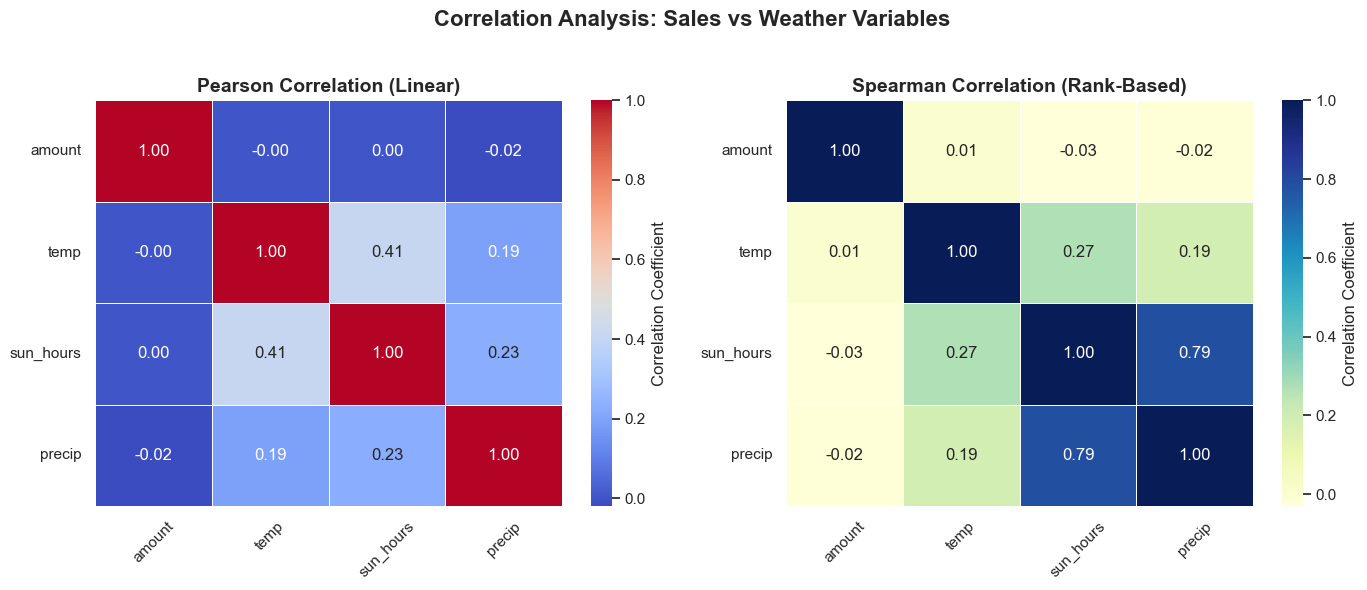

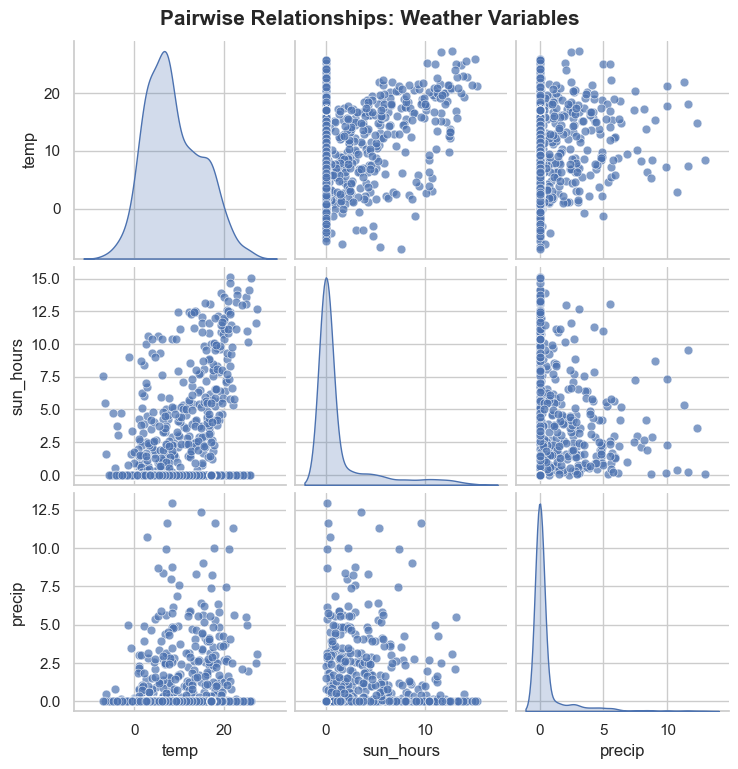


 **Automated Insights Summary:**
• Sales show a weak negative correlation with temp (-0.00, not statistically significant).
• Sales show a weak negative correlation with sun_hours (0.00, not statistically significant).
• Sales show a weak negative correlation with precip (-0.02, not statistically significant).


In [42]:

# Advanced Correlation Analysis: Sales vs Weather Variables

# Define variables of interest
features = ['temp', 'sun_hours', 'precip']
target = 'amount'

# Drop rows with NaNs in relevant columns
clean_data = merged[[target] + features].dropna()


# Compute Pearson and Spearman Correlations
pearson_corr = clean_data.corr(method='pearson').round(2)
spearman_corr = clean_data.corr(method='spearman').round(2)

print(" **Pearson Correlation Matrix (Linear Relationship):**")
display(pearson_corr)
print("\n **Spearman Correlation Matrix (Monotonic Relationship):**")
display(spearman_corr)

# Significance Testing (p-values)

print("\n **Correlation Significance (p-values)**")
p_values = {}
for col in features:
    r, p = pearsonr(clean_data[target], clean_data[col])
    p_values[col] = p
    print(f"• {col.capitalize():<10}: p-value = {p:.4f}  → {'Significant ' if p < 0.05 else 'Not Significant '}")


# Heatmap Visualization

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[0], 
            linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})
axes[0].set_title("Pearson Correlation (Linear)", fontsize=14, weight='bold')

sns.heatmap(spearman_corr, annot=True, cmap='YlGnBu', fmt=".2f", ax=axes[1], 
            linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})
axes[1].set_title("Spearman Correlation (Rank-Based)", fontsize=14, weight='bold')

for ax in axes:
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)

plt.suptitle("Correlation Analysis: Sales vs Weather Variables", fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Pairwise Relationship Visualization

sns.pairplot(
    clean_data,
    vars=features,
    hue=None,
    diag_kind='kde',
    plot_kws={'alpha': 0.7, 's': 40, 'edgecolor': 'w'},
)
plt.suptitle("Pairwise Relationships: Weather Variables", fontsize=15, y=1.02, weight='bold')
plt.show()


# Automated Insights Summary

print("\n **Automated Insights Summary:**")
for var in features:
    corr_value = pearson_corr.loc[target, var]
    significance = "significant" if p_values[var] < 0.05 else "not statistically significant"
    relation = "positive" if corr_value > 0 else "negative"
    strength = (
        "strong" if abs(corr_value) >= 0.7 else
        "moderate" if abs(corr_value) >= 0.4 else
        "weak"
    )
    print(f"• Sales show a {strength} {relation} correlation with {var} ({corr_value:.2f}, {significance}).")


# Save correlation results to CSV

pearson_corr.to_csv("correlation_results_pearson.csv", index=True)
spearman_corr.to_csv("correlation_results_spearman.csv", index=True)
